In [1]:
import torch
import pandas as pd
import numpy as np

import utils.print as print_f

from utils.coco_eval import get_eval_params_dict
from utils.engine import xami_train_one_epoch, xami_evaluate
from utils.plot import plot_loss, plot_train_val_evaluators, plot_evaluator
from utils.save import get_train_data

from models.load import ModelSetup, create_model_from_setup
from utils.save import check_best, end_train, TrainingInfo
from utils.data import get_datasets, get_dataloaders
from IPython.display import clear_output
from utils.coco_eval import get_ar_ap
from utils.init import reproducibility, clean_memory_get_device
from models.load import get_trained_model, get_current_epoch
from utils.train import get_optimiser
from utils.constants import XAMI_MIMIC_PATH, full_iou_thrs, labels_cols
from datetime import datetime

## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
# Define the trained models here:
from enum import Enum

class TrainedModels(Enum):
    
    custom_without_clinical_no_pretrained_ap = "val_ar_0_5512_ap_0_2962_test_ar_0_5999_ap_0_2319_epoch93_WithoutClincal_04-12-2022 09-15-28_custom_without_clinical_no_pretrained"
    custom_without_clinical_no_pretrained_ar = "val_ar_0_5512_ap_0_2962_test_ar_0_5999_ap_0_2319_epoch93_WithoutClincal_04-12-2022 09-15-13_custom_without_clinical_no_pretrained"
    custom_without_clinical_no_pretrained_final = "val_ar_0_4523_ap_0_2372_test_ar_0_5141_ap_0_2213_epoch100_WithoutClincal_04-12-2022 09-53-17_custom_without_clinical_no_pretrained"

    custom_with_clinical_no_pretrained_ap = "val_ar_0_4589_ap_0_2492_test_ar_0_5737_ap_0_2272_epoch78_WithClincal_04-12-2022 17-26-34_custom_with_clinical_no_pretrained"
    custom_with_clinical_no_pretrained_ar = "val_ar_0_5056_ap_0_2360_test_ar_0_5891_ap_0_2176_epoch90_WithClincal_04-12-2022 18-38-40_custom_with_clinical_no_pretrained"
    custom_with_clinical_no_pretrained_final = "val_ar_0_3470_ap_0_1944_test_ar_0_4186_ap_0_2042_epoch100_WithClincal_04-12-2022 19-38-09_custom_with_clinical_no_pretrained"


In [3]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [4]:
get_epoch_from_model = lambda select_model: int(([substr for substr in select_model.value.split("_") if "epoch" in substr][0]).replace("epoch", ""))
get_model_name = lambda select_model: str(select_model).split(".")[-1]

In [5]:
iou_thrs = full_iou_thrs
use_iobb = True

train_more_models = [
    TrainedModels.custom_without_clinical_no_pretrained_final,
    TrainedModels.custom_with_clinical_no_pretrained_final,
]

target_epoch = 200

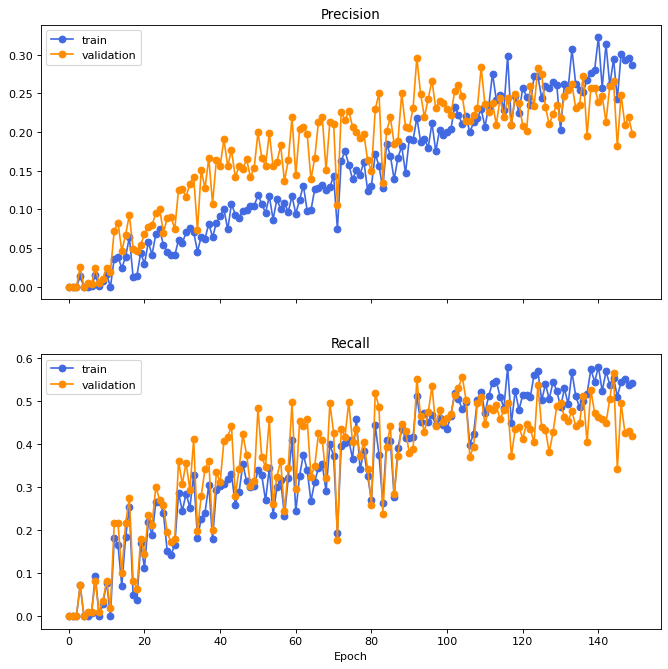

====================| Epoch [150] Done | It has took [281.57] min, Avg time: [337.88] sec/epoch | Estimate time for [100] epochs: [563.13] min |====================
====================Training model: [custom_without_clinical_no_pretrained]====================
Epoch: [151]  [  0/104]  eta: 0:01:30  lr: 0.000500  loss: 0.0006 (0.0006)  loss_classifier: 0.0005 (0.0005)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.0000 (0.0000)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.8682  data: 0.5751  max mem: 2569
Epoch: [151]  [ 10/104]  eta: 0:01:20  lr: 0.000500  loss: 0.1717 (0.1395)  loss_classifier: 0.0057 (0.0123)  loss_box_reg: 0.0060 (0.0072)  loss_mask: 0.1215 (0.1115)  loss_objectness: 0.0019 (0.0060)  loss_rpn_box_reg: 0.0009 (0.0025)  time: 0.8560  data: 0.5536  max mem: 2569
Epoch: [151]  [ 20/104]  eta: 0:01:12  lr: 0.000500  loss: 0.1696 (0.1576)  loss_classifier: 0.0080 (0.0133)  loss_box_reg: 0.0074 (0.0096)  loss_mask: 0.1405 (0.1266)  loss_objec

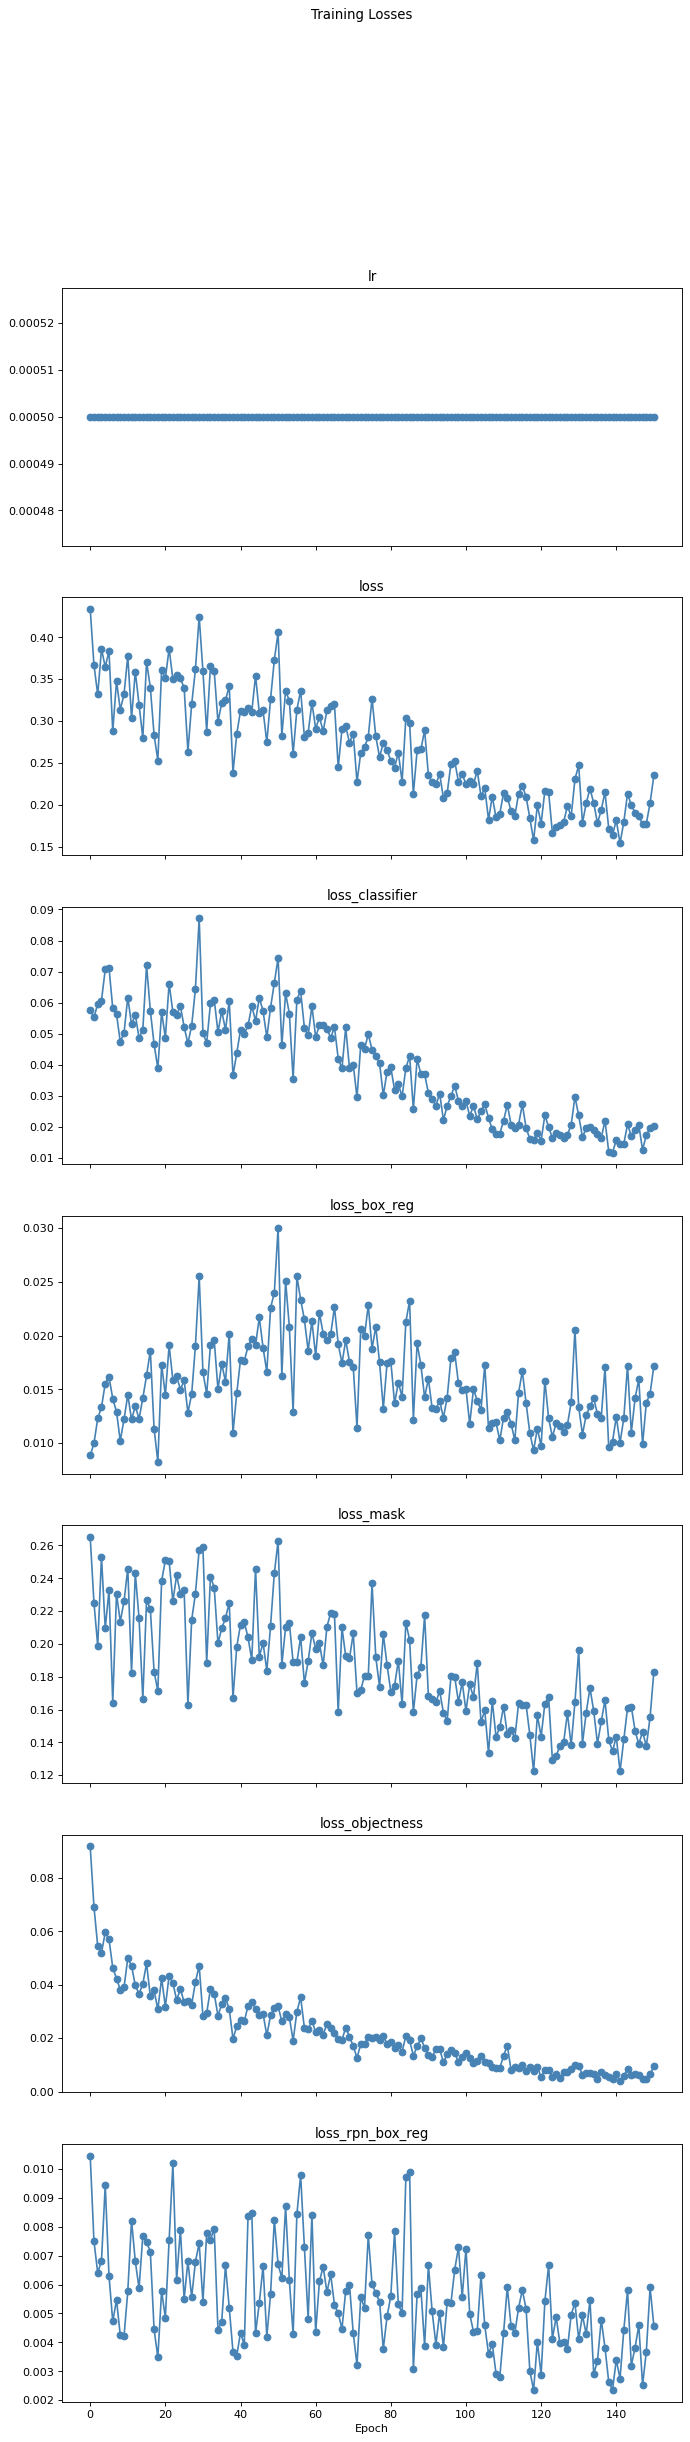

creating index...
index created!
Test:  [  0/104]  eta: 0:02:26  model_time: 0.3101 (0.3101)  evaluator_time: 0.3771 (0.3771)  time: 1.4133  data: 0.5481  max mem: 2569
Test:  [100/104]  eta: 0:00:05  model_time: 0.1710 (0.1822)  evaluator_time: 0.2851 (0.3219)  time: 1.2001  data: 0.6640  max mem: 2569
Test:  [103/104]  eta: 0:00:01  model_time: 0.1470 (0.1806)  evaluator_time: 0.2040 (0.3182)  time: 1.1606  data: 0.6456  max mem: 2569
Test: Total time: 0:02:09 (1.2455 s / it)
Averaged stats: model_time: 0.1470 (0.1806)  evaluator_time: 0.2040 (0.3182)
Accumulating evaluation results...
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoBB=0.00:1.00 | area=   all | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoBB=0.50      | area=   all | maxDets= 10 ] = 0.249
 Average Precision  (AP) @[ IoBB=0.75      | area=   all | maxDets= 10 ] = 0.112
 Average Precision  (AP) @[ IoBB=0.00:1.00 | area= small | maxDets= 10 ] = -1.

In [6]:
for select_model in train_more_models:

    # load the model.
    model, train_info, optimizer = get_trained_model(
        select_model,
        labels_cols,
        device,
        image_size=512,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )
    model.train()

    model_setup = train_info.model_setup

    # build the dataset again.
    dataset_params_dict = {
        "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
        "with_clinical": model_setup.use_clinical,
        "dataset_mode": model_setup.dataset_mode,
        "bbox_to_mask": True,
        "labels_cols": labels_cols,
    }

    detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
        dataset_params_dict=dataset_params_dict
    )

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
        train_dataset, val_dataset, test_dataset, batch_size=4
    )

    if not optimizer:
        optimizer = get_optimiser(model, model_setup,)

    lr_scheduler = None

    eval_params_dict = get_eval_params_dict(
        detect_eval_dataset, iou_thrs=iou_thrs, use_iobb=use_iobb,
    )

    # get current epoch.
    last_trainng_epoch = train_info.epoch

    num_epochs_to_run = target_epoch - last_trainng_epoch

    start_t = datetime.now()

    for e in range(last_trainng_epoch, target_epoch):

        print_f.print_title(f"Training model: [{model_setup.name}]")

        train_info.epoch = e + 1

        ###### Perform training and show the training result here ######
        model.train()

        train_loger = xami_train_one_epoch(
            model, optimizer, train_dataloader, device, train_info.epoch, print_freq=10,
        )

        train_info.train_data.append(get_train_data(train_loger))

        plot_loss(train_info.train_data)
        ################################################################

        ### update the learning rate
        if not lr_scheduler is None:
            lr_scheduler.step()

        ####### Put the model into evaluation mode, start evaluating the current model #######
        model.eval()

        if model_setup.record_training_performance:
            ### evaluate on the validation dataset
            train_evaluator = xami_evaluate(
                model, train_dataloader, device=device, params_dict=eval_params_dict
            )
            train_info.train_evaluators.append(train_evaluator)

        val_evaluator = xami_evaluate(
            model, val_dataloader, device=device, params_dict=eval_params_dict
        )

        train_info.val_evaluators.append(val_evaluator)

        ## Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
        clear_output()

        if model_setup.record_training_performance:
            plot_train_val_evaluators(
                train_info.train_evaluators,
                train_info.val_evaluators,
                areaRng="all",
                iouThr=0.5,
                maxDets=10,
            )
        else:
            plot_evaluator(
                train_info.val_evaluators, iouThr=0.5, areaRng="all", maxDets=10,
            )

        current_time = datetime.now()
        sec_took = (current_time - start_t).seconds
        speed = sec_took / (train_info.epoch - last_trainng_epoch)

        print_f.print_title(
            f"| Epoch [{train_info.epoch}] Done | It has took [{sec_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs_to_run}] epochs: [{speed*num_epochs_to_run/60:.2f}] min |"
        )

        #######################################################################################
        if model_setup.use_early_stop_model:
            val_ar, val_ap, train_info = check_best(
                device=device,
                eval_params_dict=eval_params_dict,
                train_info=train_info,
                model=model,
                optim=optimizer,
                test_dataloader=test_dataloader,
            )

    val_ar, val_ap = get_ar_ap(train_info.val_evaluators[-1])

    train_info = end_train(
        train_info=train_info,
        model=model,
        optim=optimizer,
        eval_params_dict=eval_params_dict,
        val_ar=val_ar,
        val_ap=val_ap,
        test_dataloader=test_dataloader,
        device=device,
    )
